年齢ごとに、最近の待機児童数のトレンドをグラフ化します。

In [1]:
# coding: utf-8

import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.spatial
import functools
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon

import unittest
T=unittest.TestCase()

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]
k4 = ["状況,入所の可能性 %s歳児" % i for i in "０１２３４５"]

# 補足情報を除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

# 神戸市の人口データを読み込む。
ages = ["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str, "区・支所":lambda x:str(x).replace("支所","")})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

# e-Stat の区域データを読み込む。
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く

be = [("minx",min), ("miny",min), ("maxx",max), ("maxy",max)]
pib_ext = [Point([be[j][1](pib.bounds[be[j][0]]) for j in i]) for i in ((0,1),(2,1),(2,3),(0,3))]

def proc(shinseido, zensi, target_age):
    fib_ = gpd.read_file(shinseido)
    # そのまま集計すると、分園の数だけ二重に集計してしまう
    fib = fib_[fib_["状況,参照"]!="本園"]
    # fib のセルのいくつかは数値に補足情報が付いているので、除去する
    fib_ = fib[k1+k2].applymap(drop_notes)
    fib = fib.assign(**{k:fib_[k] for k in k1+k2})
    
    return fib
    

titles = ["2016-%02d" % (i+5) for i in range(6)]
fns = (
    ("../data/hkwi/shinseido-2016-05.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-06.json","../data/kobe/zensi2805.xls"),
    ("../data/hkwi/shinseido-2016-07.json","../data/kobe/zensi2806.xls"),
    ("../data/hkwi/shinseido-2016-08.json","../data/kobe/zensi2807.xls"),
    ("../data/hkwi/shinseido-2016-09.json","../data/kobe/zensi2808.xls"),
)

In [2]:
ps = {}
for i,fn in enumerate(fns):
    shinseido_name,zensi_name = fn
    d = proc(shinseido_name, zensi_name, i).groupby("状況,地区").sum()[k2]
    d.columns = k3
    zib = load_zensi(fns[0][1]).groupby("区・支所").sum()[k3]
    d.loc["北区"] += d.loc["北神地区"]
    d = d.loc[[x for x in d.index if x != "北神地区"], :]
    ps[titles[i]] = d / zib


In [3]:
%matplotlib inline

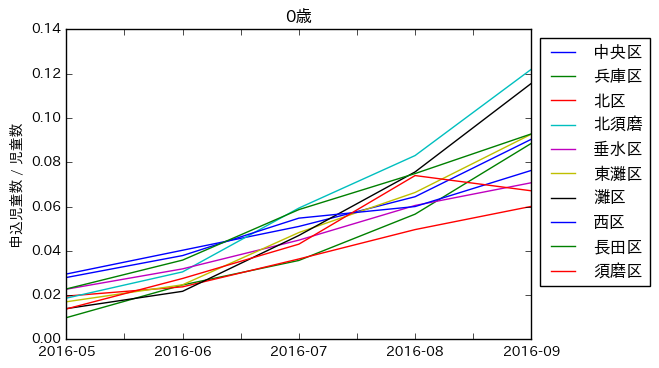

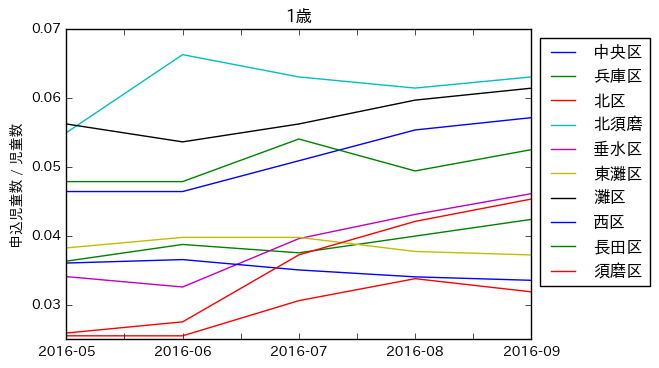

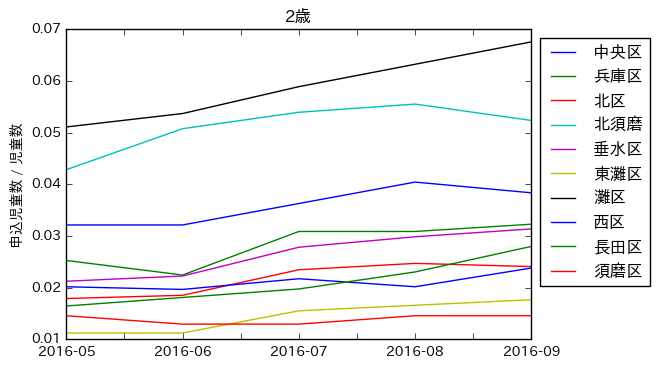

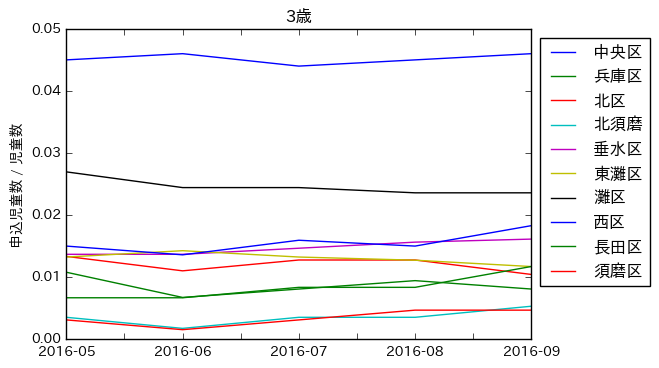

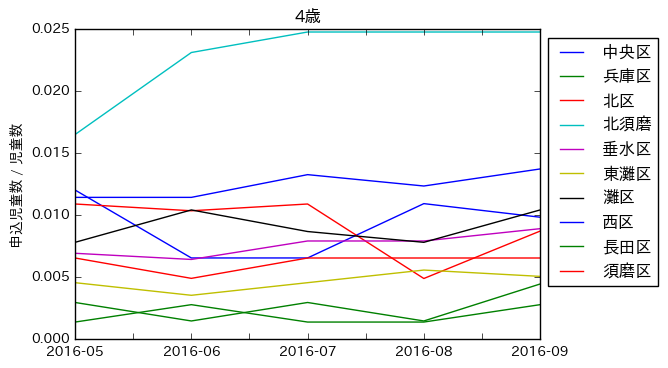

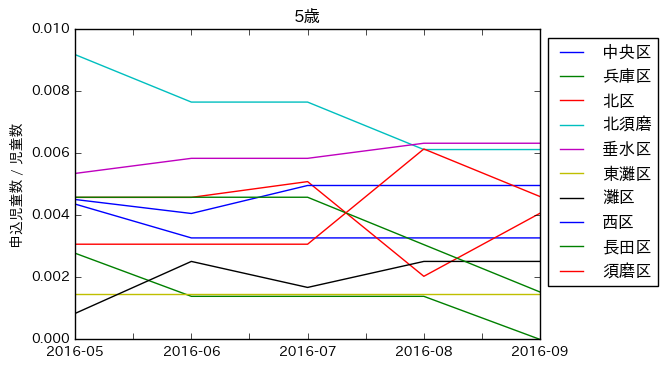

In [4]:
for k in k3:
    fig,ax = plt.subplots()
    ax.title.set_text(k)
    ax.set_ylabel("申込児童数 / 児童数")
    d = pd.DataFrame({k:v for k,v in zip(ps.keys(), [v.T.loc[k] for v in ps.values()])})
    d.T.plot(legend=False, ax=ax)
    plt.legend(d.index, bbox_to_anchor=(1,1), loc=2)